## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* **Detect lane pixels and fit to find the lane boundary.**
* **Determine the curvature of the lane and vehicle position with respect to center.**
* **Warp the detected lane boundaries back onto the original image.**
* **Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.**

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Loading the camera calibration
cameraCalib = pickle.load(open('serialized_camera_calibration/camera_calibration.p','rb'))
mtx, dist = map(cameraCalib.get, ('mtx','dist'))

# Loading perspective transformation matrices
t_matrices = pickle.load(open('perspective_xform_calibration/pt_calibration.p','rb'))
M, inv_M = map(t_matrices.get, ('M','inv_M'))

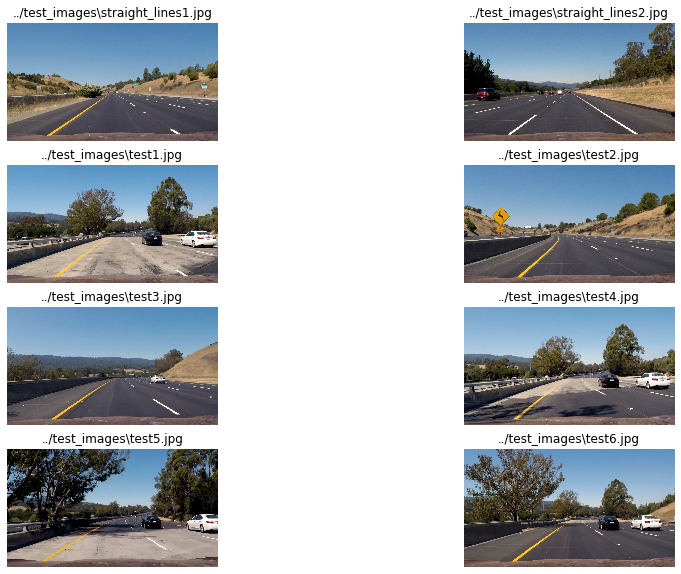

In [2]:
def show_images(images, rows = 5, cols = 4, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
            
# Loading all test images and display them
images = glob.glob('../test_images/*.jpg')
img = list(map(lambda imageFileName: (imageFileName, cv2.cvtColor(cv2.imread(imageFileName),cv2.COLOR_BGR2RGB)), images))

show_images(img, cols=2, rows=4) 

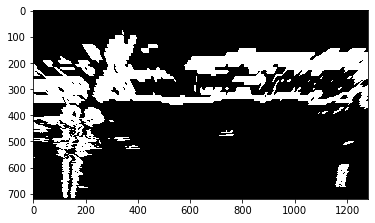

In [7]:
# Building the pipeline

def pre_pipeline(img):
    
    def img_thres(img, tmin, tmax):
        """
        To apply a threshold to the img and returning a binary image of 
        either 0 or 255
        """
        binary_img = np.zeros_like(img)
        binary_img[(img >= tmin) & (img <= tmax)] = 1
        return binary_img

    def edge_detector(img, sobel_kernel=9, tmin=0, tmax=255):
   
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
    
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        return img_thres(gradmag, tmin, tmax)
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Converting the color space from RGB to HLS
    # Selecting only the S channel as this gives the best contrast
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)[:,:,2]
    
    # Applying sobel edge detector
    edge = edge_detector(hls, 3, 20, 250)
    
    # Applying perspective transformation
    transform = cv2.warpPerspective(edge, M, (edge.shape[1],edge.shape[0]))
    
    return transform
    
binary = pre_pipeline(img[6][1])
plt.imshow(binary, cmap='gray')
    
    
    

### Detect lane pixels and fit to find the lane boundary.

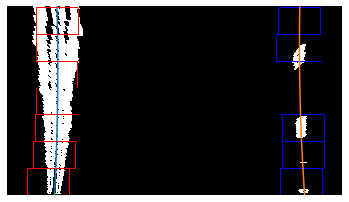

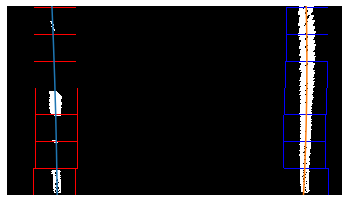

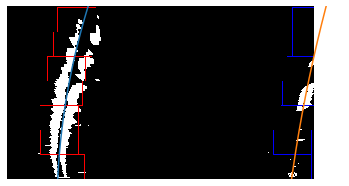

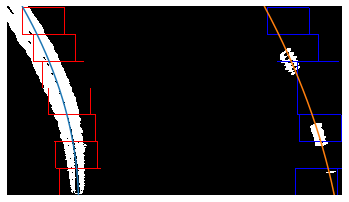

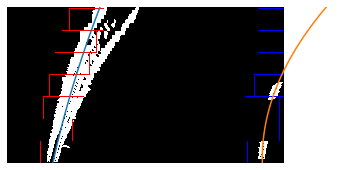

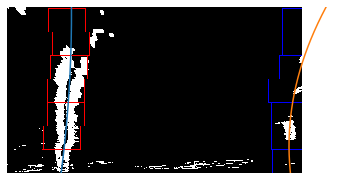

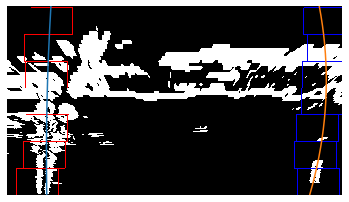

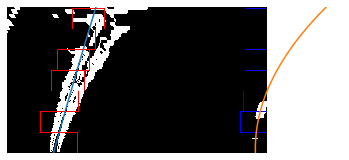

In [8]:
# Define conversions in x and y from pixel space to meters
ym_per_px = 30/720       # meters per pixel in y dimension
xm_per_px = 3.7/700      # meters per pixel in x dimension

def fit_line(img, nwindows=7, margin=80, minpx=50):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of sliding windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    """ 
    
    # Take a histogram of the bottom 30%, this means add all column into one array
    # eg [69 64 64 ... 0 0 0]
    histogram = np.sum(img[int(img.shape[0]*0.6):,:], axis=0)
    # Create an output image to draw on and visualize the result
    # np.dstack() function stacks arrays in sequence depth wise
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    width = np.int(histogram.shape[0])
    left_base = np.argmax(histogram[:np.int(0.3*width)])
    right_base = np.argmax(histogram[-1*np.int(0.3*width):]) + np.int(width*0.7)
    
    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    # nonzero() function returns tuple of ([row_index],[col_index]) of non zero elements
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # To store the left and right lane pixel indices
    left_lane_ind = []
    right_lane_ind = []
        
    def sliding_window(in_img,out_img,l_base,r_base):
        # Current left and right position
        current_left = l_base
        current_right = r_base
        
        for i in range(nwindows):
            
            # Identify window boundaries in x and y
            win_y_low = img.shape[0] - (i+1)*window_height
            win_y_high = img.shape[0] - i*window_height
            win_xleft_low = current_left - margin
            win_xleft_high = current_left + margin
            win_xright_low = current_right - margin
            win_xright_high = current_right + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,0,255), 2)
            
            # Identify the nonzero pixels in x and y within the window
            valid_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            valid_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_ind.append(valid_left_inds)
            right_lane_ind.append(valid_right_inds)
            
            # If you found > minpx pixels, recenter next window on their mean position
            if len(valid_left_inds) > minpx:
                current_left = np.int(np.mean(nonzerox[valid_left_inds]))
            if len(valid_right_inds) > minpx:        
                current_right = np.int(np.mean(nonzerox[valid_right_inds]))
            
    sliding_window(img,out_img,left_base,right_base)
    
    # Concatenate the arrays of indices
    left_lane_ind = np.concatenate(left_lane_ind)
    right_lane_ind = np.concatenate(right_lane_ind)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_ind]
    lefty = nonzeroy[left_lane_ind] 
    rightx = nonzerox[right_lane_ind]
    righty = nonzeroy[right_lane_ind]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_px, leftx*xm_per_px, 2)
    right_fit_m = np.polyfit(righty*ym_per_px, rightx*xm_per_px, 2)
        
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_ind, right_lane_ind, out_img, nonzerox, nonzeroy)
    
def draw_lines(img, left_fit, right_fit):
    """
    Visualization function for the transformed image line fit to check for correction
    """
    
    # Building the second order equation
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_line_eq = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_line_eq = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    plt.figure()
    plt.imshow(img)
    plt.plot(left_line_eq, y)
    plt.plot(right_line_eq, y)
    plt.axis('off')

for i in range(len(img)):
    binary = pre_pipeline(img[i][1])
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_ind, right_lane_ind, out_img, nonzerox, nonzeroy = fit_line(binary)
    draw_lines(out_img, left_fit, right_fit)
    

### Determine the curvature of the lane and vehicle position with respect to center
The distance from center makes two assumptions:

1. The camera is located dead-center on the car

2. The lane width follows US regulation (3.7m)



Radius of curvature formula is given by:

$$R_{curve} = \frac{[1+(2Ay+B)^{2}]^{3/2}}{\left |2A\right |}$$

In [5]:
def calcCurvature(y_pixel, coeff):
    """
    Calculate the curvature of the road in real unit metric radius
    """
    return ((1 + (2*coeff[0]*y_pixel*ym_per_px + coeff[1])**2)**1.5) / np.absolute(2*coeff[0])


for i in range(len(img)):
    binary = pre_pipeline(img[i][1])
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_ind, right_lane_ind, out_img, nonzerox, nonzeroy = fit_line(binary)
    y_pixel = binary.shape[0]
    l_curvature = calcCurvature(y_pixel, left_fit_m) / 1000
    r_curvature = calcCurvature(y_pixel, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(img[i][0], l_curvature, r_curvature))
    

Image : ../test_images\straight_lines1.jpg, Left : 3.06 km, Right : 2.71 km
Image : ../test_images\straight_lines2.jpg, Left : 7.26 km, Right : 3.17 km
Image : ../test_images\test1.jpg, Left : 0.91 km, Right : 1.93 km
Image : ../test_images\test2.jpg, Left : 0.44 km, Right : 0.72 km
Image : ../test_images\test3.jpg, Left : 1.44 km, Right : 0.27 km
Image : ../test_images\test4.jpg, Left : 1.75 km, Right : 0.37 km
Image : ../test_images\test5.jpg, Left : 3.14 km, Right : 0.49 km
Image : ../test_images\test6.jpg, Left : 8.91 km, Right : 0.23 km


### Warp the detected lane boundaries back onto the original image and add visual display of the numerical estimation of lane curvature and vehicle position

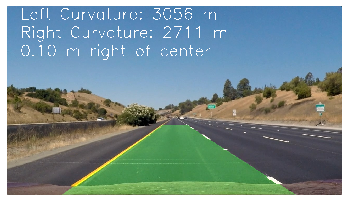

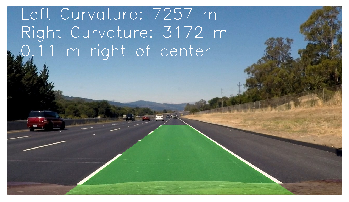

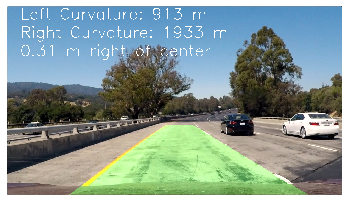

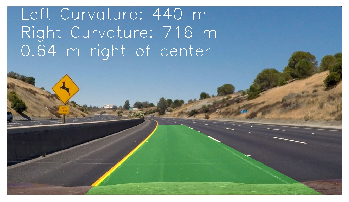

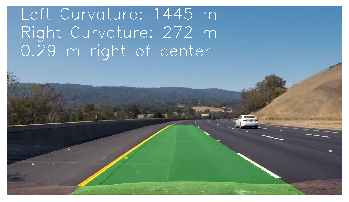

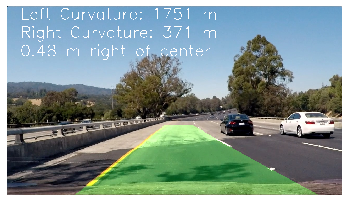

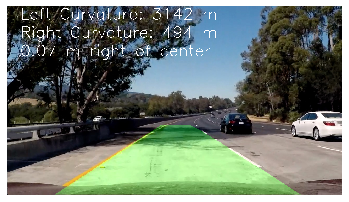

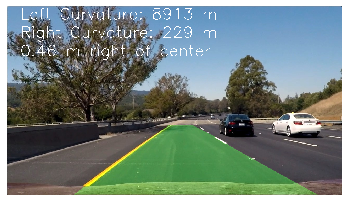

In [6]:
def draw_poly(img, l_eq, r_eq):
    """
    Draw lane lines
    """
    
    height = img.shape[0]
    y = np.linspace(0, height - 1, height)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_x = l_eq[0]*y**2 + l_eq[1]*y + l_eq[2]
    right_x = r_eq[0]*y**2 + r_eq[1]*y + r_eq[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, y])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, inv_M, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, unwarp, 0.3, 0)

for i in range(len(img)):
    current_img = img[i][1]
    binary = pre_pipeline(img[i][1])
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_ind, right_lane_ind, out_img, nonzerox, nonzeroy = fit_line(binary)
    
    y_pixel = binary.shape[0]
    l_curvature = calcCurvature(y_pixel, left_fit_m)
    r_curvature = calcCurvature(y_pixel, right_fit_m)
    
    # Calculate vehicle center
    width = current_img.shape[1]*xm_per_px
    height = current_img.shape[0]*ym_per_px
    center = width / 2
    lineLeft = left_fit_m[0]*height**2 + left_fit_m[1]*height + left_fit_m[2]
    lineRight = right_fit_m[0]*height**2 + right_fit_m[1]*height + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - center
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
        
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    fontColor = (255, 255, 255)
    cv2.putText(current_img, 'Left Curvature: {:.0f} m'.format(l_curvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(current_img, 'Right Curvature: {:.0f} m'.format(r_curvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(current_img, '{} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    
    plt.figure()
    plt.imshow(draw_poly(current_img, left_fit, right_fit))
    plt.axis('off')
    
    